In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In this notebook I'm going to explore a fake news dataset that can be found on [Kaggle]('https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset'). Before applying a classification algorithm on the data, I'm trying to extract some insights that will be later used in the preprocessing step. I'll check if there are any missing or duplicate values, what is the distribution of values across several fields in the dataset or if I can detect any sources of bias.  
<br/>
The original dataset is splitted in 2 csv files (fake and true). I'll import them individually and after some quick analysis I'll mix the 2 sources in a single pandas dataframe.

In [3]:
df_fake = pd.read_csv('../../data/raw/Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
df_fake['fake'] = 1

In [5]:
df_true = pd.read_csv('../../data/raw/True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
df_true['fake'] = 0

In [7]:
data = pd.concat([df_true, df_fake], ignore_index=True, sort=False)
data

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [8]:
# Check for null values
data.isnull().sum()

title      0
text       0
subject    0
date       0
fake       0
dtype: int64

Fortunately, there are no missing values.

In [9]:
data.fake.value_counts()

1    23481
0    21417
Name: fake, dtype: int64

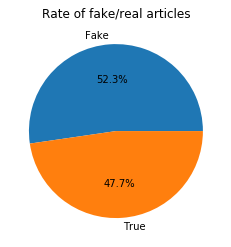

In [10]:
plt.pie(data.fake.value_counts().values, 
            labels=['Fake' if x == 1 else 'True' for x in data.fake.value_counts().index],
            autopct='%1.1f%%')
plt.title("Rate of fake/real articles")
plt.show()


We can notice that the distribution of classes is balanced.

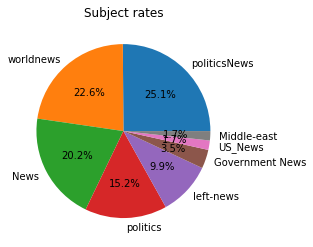

In [11]:
plt.pie(data.subject.value_counts().values, 
            labels=data.subject.value_counts().index,
            autopct='%1.1f%%')
plt.title("Subject rates")
plt.show()

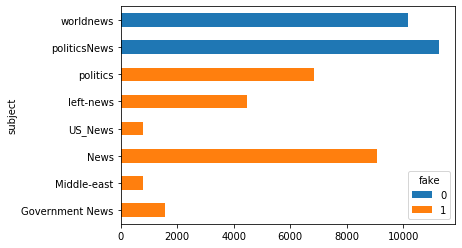

In [12]:
data.groupby(['subject', 'fake'])['subject'].count().unstack('fake').fillna(0).plot.barh(stacked=True)

Apparently, fake and true news don't have overlapping subjects (although we may consider 'politicsNews' and 'politics' the same category). True articles' subjects only fall within 2 categories (world news and politics news), whereas fake news subjects classification is a bit more granular. However, there isn't much information that can be subtracted from this particular field. Moreover, using this field as a feature during training may add unwanted bias to the dataset. This is why I'm going to exclude it from the training process.

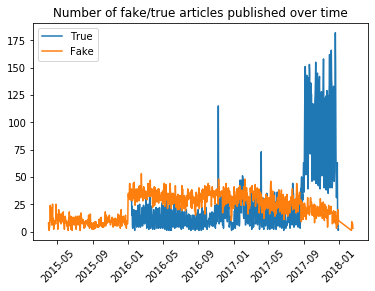

In [13]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
true_counts_by_date = data[data['fake'] == 0]['date'].value_counts().sort_index()
fake_counts_by_date = data[data['fake'] == 1]['date'].value_counts().sort_index()

plt.plot(true_counts_by_date.index, true_counts_by_date.values, label='True')
plt.plot(fake_counts_by_date.index, fake_counts_by_date.values, label='Fake')
plt.title("Number of fake/true articles published over time")
plt.legend()
plt.xticks(rotation=45)
plt.show()


We can notice that between 2015 and beginning of 2016 the dataset contains only fake news. Also, after September 2017 the ammount of true articles is significantly larger than the ammount of fake news. This can also be a source of bias in the dataset. In the preprocessing phase I'll remove the date column as well and only rely on the text content of the dataset.

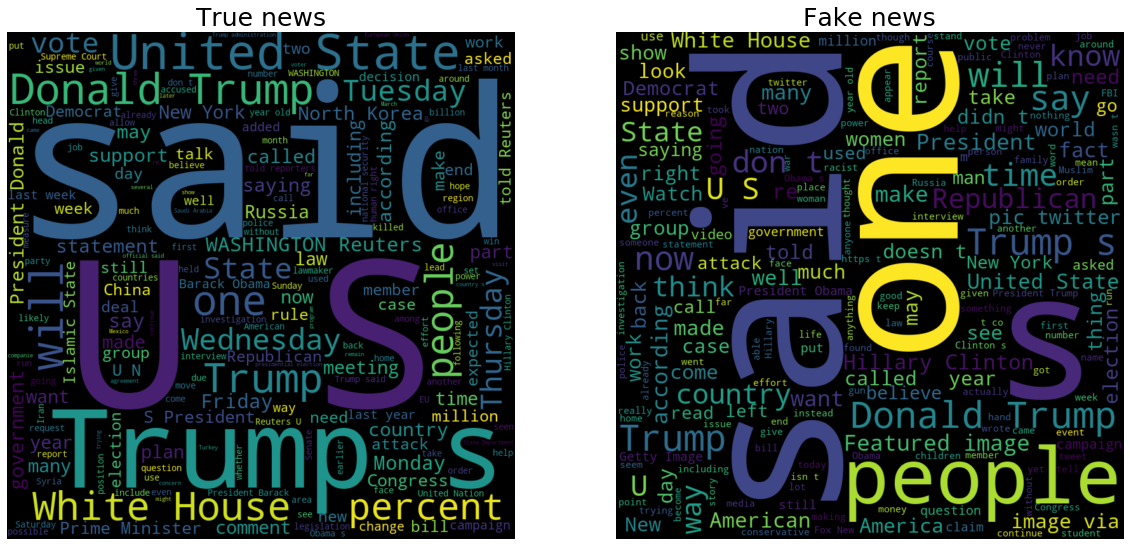

In [14]:
plt.figure(figsize=(20,10))

true_texts_wordcloud = WordCloud(width = 800 , height = 800 , stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.fake == 0].text))
fake_texts_wordcloud = WordCloud(width = 800 , height = 800, stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.fake == 1].text))

plt.subplot(121)
plt.axis("off")
plt.title('True news', fontdict={'fontsize': 25})
plt.imshow(true_texts_wordcloud, interpolation='bilinear')

plt.subplot(122)
plt.axis("off")
plt.title('Fake news', fontdict={'fontsize': 25})
plt.imshow(fake_texts_wordcloud, interpolation='bilinear')

plt.show()

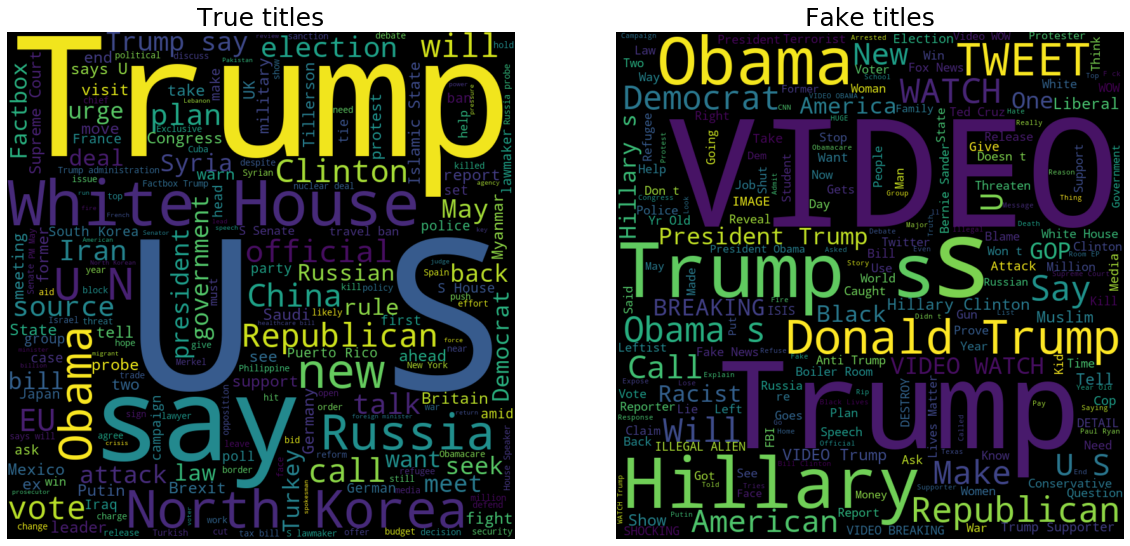

In [15]:
plt.figure(figsize=(20,10))

true_titles_wordcloud = WordCloud(width = 800 , height = 800 , stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.fake == 0].title))
fake_titles_wordcloud = WordCloud(width = 800 , height = 800, stopwords = STOPWORDS)\
                    .generate(" ".join(data[data.fake == 1].title))

plt.subplot(121)
plt.axis("off")
plt.title('True titles', fontdict={'fontsize': 25})
plt.imshow(true_titles_wordcloud, interpolation='bilinear')

plt.subplot(122)
plt.axis("off")
plt.title('Fake titles', fontdict={'fontsize': 25})
plt.imshow(fake_titles_wordcloud, interpolation='bilinear')

plt.show()

These word clouds help us understand which are the most common words that appear in both fake and true articles/titles. We can easily notice that they are related to the geopolitcal area, mainly referring to 2016 USA presidential elections.

Text(0.5, 1.0, 'Article titles length')

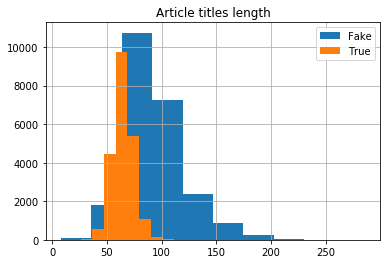

In [16]:
data[data.fake == 1].title.str.len().hist(label = 'Fake')
data[data.fake == 0].title.str.len().hist(label = 'True')
plt.legend(loc='upper right')
plt.title("Article titles length")

It's interesting to notice that fake news titles tend to be longer.

Text(0.5, 1.0, 'Article texts length')

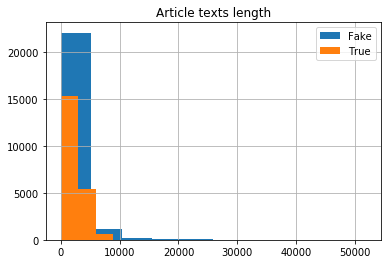

In [17]:
data[data.fake == 1].text.str.len().hist(label = 'Fake')
data[data.fake == 0].text.str.len().hist(label = 'True')
plt.legend(loc='upper right')
plt.title("Article texts length")

In [18]:
print("Fake news articles length stats")
data[data.fake == 1].text.str.len().describe()

Fake news articles length stats


count    23481.000000
mean      2547.396235
std       2532.884399
min          1.000000
25%       1433.000000
50%       2166.000000
75%       3032.000000
max      51794.000000
Name: text, dtype: float64

In [19]:
print("True news articles length stats")
data[data.fake == 0].text.str.len().describe()

True news articles length stats


count    21417.000000
mean      2383.278517
std       1684.835730
min          1.000000
25%        914.000000
50%       2222.000000
75%       3237.000000
max      29781.000000
Name: text, dtype: float64

It looks like fake news texts are also a bit longer than the true ones. The same observation applies to news titles.
At the same time, we can notice that there some articles that contain a single character. These are probably empty articles. We'll look into more detail below.

In [20]:
data[data.text.str.len() == 1].sort_values(by='fake')

,title,text,subject,date,fake
8970,Graphic: Supreme Court roundup,,politicsNews,2016-06-16,0
37602,WATCH FULL RESPONSE FROM TRUMP AFTER OBAMACARE...,,Government News,2017-03-24,1
37606,‘ANGEL’ MOMS of Sons Killed by Illegals Weigh ...,,Government News,2017-03-22,1
37607,WHICH ONE OF THESE PEOPLE Tried to Lecture the...,,Government News,2017-03-21,1
37609,WATCH: TED CRUZ SKEWERS DEMS for Hypocritical ...,,Government News,2017-03-21,1
...,...,...,...,...,...
33674,CNN HOST Suggests Women Wear Muslim Headscarf ...,,politics,2016-11-30,1
33678,OOPS! SEN COONS ADMITS REGRET MAKING IT EASIER...,,politics,2016-11-30,1
33685,FOX HOST KENNEDY Gives Jill Stein An Earful: ‘...,,politics,2016-11-29,1
33650,WATCH TUCKER CARLSON Face Off With New York Ti...,,politics,2016-12-03,1


In [21]:
data[data.text.str.len() == 1].title.str.len().describe()

count    627.000000
mean      93.377990
std       25.060165
min       29.000000
25%       77.000000
50%       89.000000
75%      105.000000
max      224.000000
Name: title, dtype: float64

Alright! So the dataset contains a single empty 'true' article. The rest of 626 empty articles are under the fake category. However, although these are empty articles, their corresponding title is non-empty.

In [22]:
data[data['fake'] == 0].text

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - Transgender people will...
2        WASHINGTON (Reuters) - The special counsel inv...
3        WASHINGTON (Reuters) - Trump campaign adviser ...
4        SEATTLE/WASHINGTON (Reuters) - President Donal...
                               ...                        
21412    BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413    LONDON (Reuters) - LexisNexis, a provider of l...
21414    MINSK (Reuters) - In the shadow of disused Sov...
21415    MOSCOW (Reuters) - Vatican Secretary of State ...
21416    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 21417, dtype: object

In [23]:
data[data['fake'] == 1].text

21417    Donald Trump just couldn t wish all Americans ...
21418    House Intelligence Committee Chairman Devin Nu...
21419    On Friday, it was revealed that former Milwauk...
21420    On Christmas day, Donald Trump announced that ...
21421    Pope Francis used his annual Christmas Day mes...
                               ...                        
44893    21st Century Wire says As 21WIRE reported earl...
44894    21st Century Wire says It s a familiar theme. ...
44895    Patrick Henningsen  21st Century WireRemember ...
44896    21st Century Wire says Al Jazeera America will...
44897    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 23481, dtype: object

In [24]:
data[data['text'].str.contains("Reuters")].fake.value_counts()

0    21378
1      311
Name: fake, dtype: int64

In [25]:
data[data['text'].str.contains("WASHINGTON \(Reuters\)")].fake.value_counts()

0    6663
1       3
Name: fake, dtype: int64

It is important to notice that the great majority of articles labeled as **True news** contain "(Reuters)" as an explicit source information. "(Reuters)" is usually preceeded by a city name. As we can see above, "WASHINGTON (Reuters)" appears 6663 times across true articles. This will make the dataset biased, because a model can obtain great accuracy taking into account just a single word encounter. In the preprocessing step of the data I'll remove all the appearances of "Reuters" to prevent the algorithms from "cheating".

In [26]:
data.duplicated(subset=['text']).sum()

6252

The dataset contains 6252 duplicated articles that will also be removed in the preprocessing step. 625 of these duplicates are the empty fake news.